In [1]:
import yfinance as yf
import pandas as pd
import sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

plt.rcParams["figure.figsize"] = [20, 6]

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

C:\Users\acer\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\acer\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\acer\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2015,1,4)
end = datetime.datetime(2019,1,1)
train_df = web.DataReader("AAPL", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,4)
end = datetime.datetime(2020,1,1)
test_df = web.DataReader("AAPL", 'yahoo', start, end)

In [10]:
# sort by date
train_df = train_df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
train_df.reset_index(inplace=True)
train_df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

In [11]:
# returns = train_df["Adj Close"] + train_df["Dividends"]

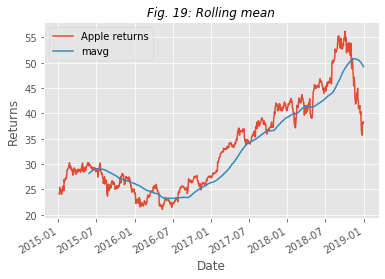

In [12]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.plot(train_df["Adj Close"])
#plt.xlabel('Date',fontsize=15)
#plt.ylabel('Adjusted Close Price',fontsize=15)
#plt.show()

# Rolling mean
close_px = train_df['Adj Close']
mavg = close_px.rolling(window=100).mean()

close_px.plot(label='Apple returns')
plt.title("Fig. 19: Rolling mean", fontsize=12, fontstyle = 'italic')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

In [13]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = train_df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1000,737052.0,37.887501,36.647499,37.037498,36.707500,148676800.0,35.686825
1001,737054.0,39.307499,36.680000,37.075001,39.292500,234330000.0,38.199944
1002,737055.0,39.192501,37.517502,38.959999,39.037498,212468400.0,37.952026
1003,737056.0,39.630001,38.637501,39.375000,39.057499,169165600.0,37.971478
1004,737059.0,39.840000,39.119999,39.632500,39.435001,140014000.0,38.338482


In [88]:
# LSTM

In [89]:
# Create train set of adj close prices data:
train_data = train_df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape)


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1005,)


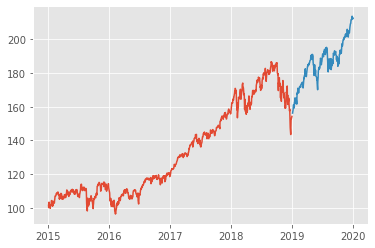

In [90]:
# plot train and test set

plt.plot(train_df['Close'])
plt.plot(test_df['Close'])

In [91]:
# Function to create a dataset to feed into an LSTM

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [92]:
# define time_window = number of observations from which we imply the future observation

time_window = 3

In [93]:
# Create the data to train our model on:
time_steps = time_window
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1002, 3, 1)
X_train:
[[95.90097046]
 [94.61512756]
 [95.83480072]]


y_train: [[97.66906738]]



In [94]:
# Build the model 

model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))

# model.add(LSTM(units = 100, return_sequences = True))
# model.add(Dropout(0.1))

model.add(LSTM(units = 100))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.optimizer.lr.assign(0.001)

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 300, batch_size = 50, validation_split=.10)

Epoch 1/300
19/19 [==============================] - 1s 35ms/step - loss: 0.0781 - val_loss: 0.0031
Epoch 2/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0095
Epoch 3/300
19/19 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 4/300
19/19 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 5/300
19/19 [==============================] - 0s 5ms/step - loss: 9.0915e-04 - val_loss: 0.0018
Epoch 6/300
19/19 [==============================] - 0s 5ms/step - loss: 8.9960e-04 - val_loss: 0.0025
Epoch 7/300
19/19 [==============================] - 0s 5ms/step - loss: 7.8167e-04 - val_loss: 0.0017
Epoch 8/300
19/19 [==============================] - 0s 5ms/step - loss: 8.6332e-04 - val_loss: 0.0022
Epoch 9/300
19/19 [==============================] - 0s 5ms/step - loss: 8.4315e-04 - val_loss: 0.0018
Epoch 10/300
19/19 [==============================] - 0s 5ms/step - loss: 7.5675e-04 - v

19/19 [==============================] - 0s 5ms/step - loss: 6.2373e-04 - val_loss: 0.0015
Epoch 159/300
19/19 [==============================] - 0s 5ms/step - loss: 5.0496e-04 - val_loss: 0.0016
Epoch 160/300
19/19 [==============================] - 0s 5ms/step - loss: 6.1961e-04 - val_loss: 0.0018
Epoch 161/300
19/19 [==============================] - 0s 5ms/step - loss: 5.3977e-04 - val_loss: 0.0015
Epoch 162/300
19/19 [==============================] - 0s 5ms/step - loss: 5.4057e-04 - val_loss: 0.0016
Epoch 163/300
19/19 [==============================] - 0s 5ms/step - loss: 5.3850e-04 - val_loss: 0.0020
Epoch 164/300
19/19 [==============================] - 0s 5ms/step - loss: 6.8260e-04 - val_loss: 0.0014
Epoch 165/300
19/19 [==============================] - 0s 5ms/step - loss: 6.3765e-04 - val_loss: 0.0017
Epoch 166/300
19/19 [==============================] - 0s 5ms/step - loss: 5.9971e-04 - val_loss: 0.0019
Epoch 167/300
19/19 [==============================] - 0s 5ms/step - 

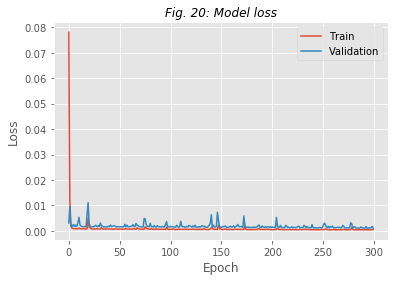

In [95]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Fig. 20: Model loss', fontsize=12, fontstyle = 'italic')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

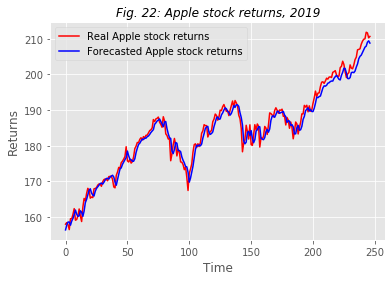

In [96]:
# Get the stock prices for 2019 to have our model make the predictions

test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = time_window
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Apple stock returns')
plt.plot(predicted_y, color = 'blue', label = 'Forecasted Apple stock returns')
plt.title('Fig. 22: Apple stock returns, 2019', fontsize=12, fontstyle = 'italic')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [97]:
# obtain the test MSE

test_mse = sum(predicted_y - org_y)**2 / len(org_y)
test_mse

array([95.71363493])

In [98]:
# hit ratio

predictions_updown = list()
real_updown = list()

prev_price = test_data[(time_window-1)]
for t in range(len(test_data)-time_window):
    predictions_updown.append(predicted_y[t] - prev_price)
    real_updown.append(test_data[time_window + t] - prev_price)
    if t+1 < len(test_data) -(time_window-1):
        prev_price = test_data[(time_window-1) + t+1]

correct_count = 0
for i in range(len(real_updown)):
    if ((real_updown[i] > 0) and (predictions_updown[i] > 0)) or(( real_updown[i] <= 0) and (predictions_updown[i] <= 0)):
        correct_count += 1
    
print(correct_count / len(real_updown))

In [104]:
# opposite hit ratio

1 - (correct_count / len(real_updown))

0.40485829959514175